In [13]:
import pandas as pd
import numpy as np
import os
import gzip
from functools import reduce

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.linear_model import LinearRegression as lr

In [14]:
data_path = '../../../ecme/UC1: Digital Platform/Data/'

In [15]:
os.listdir(data_path)

['POLICY_NETWORK.csv.gzip',
 'Reviews_historical.csv.gzip',
 'PARTIES_DOMAIN_FEATURE.csv.gzip',
 'CONTRACT_PARTIES.csv.gzip',
 'total_reviews.csv',
 'CONTRACT_EVENTS.csv.gzip',
 'EVENTS_DOMAIN_FEATURE.csv.gzip',
 'total_listings.csv',
 'ASSETS_DOMAIN_FEATURE.csv.gzip',
 'Listing_historical.csv.gzip',
 'capitals.csv',
 'CONTRACT_ASSET.csv.gzip']

In [16]:
with gzip.open(data_path + 'ASSETS_DOMAIN_FEATURE.csv.gzip') as file_in:
    df_asset = pd.read_csv(file_in, low_memory=False)

In [17]:
df_asset.columns

Index(['MODEL_INSTANCE', 'PARTIES_ID', 'ASSET_ID', 'DATE_YEAR_MONTH',
       'ASSETS_NAME', 'ASSETS_TYPE', 'ASSETS_DESCRIPTION',
       'ASSETS_HOST_NEIGHBOURHOOD', 'ASSETS_NEIGHBORHOOD_OVERVIEW',
       'ASSETS_LATITUDE', 'ASSETS_LONGITUDE', 'ASSETS_PROPERTY_TYPE',
       'ASSETS_ROOM_TYPE', 'ASSETS_BEDROOMS', 'ASSETS_RETING_PRICE',
       'ASSETS_REQUIRES_LICENS', 'ASSETS_REVIEW_SCORES_ACCURACY',
       'ASSETS_REVIEW_SCORES_CHECKIN', 'ASSETS_REVIEW_SCORES_CLEANLINESS',
       'ASSETS_REVIEW_SCORES_COMMUNICATION', 'ASSETS_REVIEW_SCORES_LOCATION',
       'ASSETS_REVIEW_SCORES_RATING', 'ASSETS_REVIEW_SCORES_VALUE',
       'ASSETS_REVIEW_PER_MONTH', 'PARTIES_ID_y', 'TIME_STAMP',
       'ASSET_MIGRATION', 'ASSET_LOCATION', 'ASSET_NUMBER_REVIEWS',
       'ASSET_PRICE', 'ASSET_AVAILABILITY_30'],
      dtype='object')

In [18]:
df_asset.rename(columns={'ASSET_MIGRATION' :'ASSET_MITIGATION_COVID'}, inplace=True)

In [19]:
df_asset.head()

,MODEL_INSTANCE,PARTIES_ID,ASSET_ID,DATE_YEAR_MONTH,ASSETS_NAME,ASSETS_TYPE,ASSETS_DESCRIPTION,ASSETS_HOST_NEIGHBOURHOOD,ASSETS_NEIGHBORHOOD_OVERVIEW,ASSETS_LATITUDE,...,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE,ASSETS_REVIEW_PER_MONTH,PARTIES_ID_y,TIME_STAMP,ASSET_MITIGATION_COVID,ASSET_LOCATION,ASSET_NUMBER_REVIEWS,ASSET_PRICE,ASSET_AVAILABILITY_30
0,PJNs4Fpyg4,62142,15883,2015-04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rGvohKWuaC,62142,15883,2016-06,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,100.0,10.0,0.07,62142.0,2016-06-04,0.0,vienna,1.0,$85.00,9.0
2,O1ZE3GDKxL,62142,15883,2016-07,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,100.0,10.0,0.13,62142.0,2016-07-06,0.0,vienna,2.0,$85.00,17.0
3,2t2vxoLsH5,62142,15883,2016-08,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,93.0,9.0,0.19,62142.0,2016-08-05,0.0,vienna,3.0,$85.00,9.0
4,KBHJiEPuFf,62142,15883,2016-11,Eva,Real Bed,"Four rooms, each one differently and individua...",Donaustadt,"small and personal Four rooms at this B&B, eac...",48.241436,...,90.0,9.0,0.21,62142.0,2016-11-09,0.0,vienna,4.0,$85.00,9.0


In [20]:
df_asset[df_asset.ASSET_MITIGATION_COVID==1].shape

(394, 31)

In [21]:
test = df_asset[df_asset.ASSET_MITIGATION_COVID==1]

In [22]:
len(test.ASSET_ID.unique())

134

In [23]:
test.groupby("ASSET_LOCATION").agg({"ASSET_ID" : 'nunique'})

,ASSET_ID
ASSET_LOCATION,
amsterdam,44
brussels,21
copenhagen,1
dublin,1
lisbon,28
madrid,37
vienna,2


In [24]:
test.pivot_table(index='ASSET_LOCATION', 
                 columns='DATE_YEAR_MONTH', 
                 values="ASSET_ID" , 
                 aggfunc='nunique')

DATE_YEAR_MONTH,2020-03,2020-04,2020-05,2020-06,2020-07
ASSET_LOCATION,,,,,
amsterdam,NaN,NaN,9.0,17.0,40.0
brussels,2.0,2.0,9.0,15.0,NaN
copenhagen,NaN,NaN,NaN,1.0,NaN
dublin,NaN,NaN,1.0,NaN,NaN
lisbon,NaN,NaN,7.0,21.0,NaN
madrid,NaN,NaN,5.0,32.0,NaN
vienna,NaN,NaN,NaN,2.0,NaN


In [25]:
covid = df_asset[df_asset.DATE_YEAR_MONTH == "2020-06"]\
            .sort_values(by=["ASSET_ID", "TIME_STAMP"])\
            .groupby(["ASSET_ID"])\
            .tail(1)[["DATE_YEAR_MONTH", "ASSET_ID", "ASSET_LOCATION", "ASSET_MITIGATION_COVID"]]

In [26]:
covid.shape

(12837, 4)

In [27]:
pre_codiv = df_asset[df_asset.DATE_YEAR_MONTH == "2019-06"]\
                .sort_values(by=["ASSET_ID", "TIME_STAMP"])\
                .groupby(["ASSET_ID"])\
                .tail(1)[["DATE_YEAR_MONTH", "ASSET_ID"]]

In [28]:
pre_codiv.shape

(62737, 2)

In [29]:
df_covid = covid[["DATE_YEAR_MONTH", "ASSET_ID", "ASSET_MITIGATION_COVID"]]\
            .merge(pre_codiv[["ASSET_ID"]], on="ASSET_ID", how='inner')

In [30]:
df_covid.shape

(7539, 3)

In [31]:
df_covid.ASSET_MITIGATION_COVID.sum()

64.0

In [32]:
df_asset_sub = df_asset.loc[(df_asset.DATE_YEAR_MONTH == "2019-06") | 
                            (df_asset.DATE_YEAR_MONTH == "2020-06")]

In [33]:
df_asset_sub.shape

(240763, 31)

In [34]:
#ASSET_PRICE
def fix_price (value):
    try:
        value = value.replace("$", '').replace(",", '')
        value = float(value)
        return value
    except: return np.nan  

df_asset_sub['ASSET_PRICE'] = df_asset_sub['ASSET_PRICE'].apply(lambda x : fix_price(x))

In [35]:
# CZK TO EURO --> 0.039
df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='prague', "ASSET_PRICE"] = df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='prague', "ASSET_PRICE"] * 0.039

# DKK TO EURO --> 0.13
df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='copenhagen', "ASSET_PRICE"] = df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='copenhagen', "ASSET_PRICE"] * 0.13

# KR TO EURO --> 0.099
df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='stockholm', "ASSET_PRICE"] = df_asset_sub.loc[df_asset_sub.ASSET_LOCATION=='stockholm', "ASSET_PRICE"] * 0.099

In [36]:
df_asset_sub.head(2)

,MODEL_INSTANCE,PARTIES_ID,ASSET_ID,DATE_YEAR_MONTH,ASSETS_NAME,ASSETS_TYPE,ASSETS_DESCRIPTION,ASSETS_HOST_NEIGHBOURHOOD,ASSETS_NEIGHBORHOOD_OVERVIEW,ASSETS_LATITUDE,...,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE,ASSETS_REVIEW_PER_MONTH,PARTIES_ID_y,TIME_STAMP,ASSET_MITIGATION_COVID,ASSET_LOCATION,ASSET_NUMBER_REVIEWS,ASSET_PRICE,ASSET_AVAILABILITY_30
291,wlkU0LlYHy,166283,38768,2019-06,Hannes,Real Bed,39m² apartment with beautiful courtyard of the...,Leopoldstadt,the Karmeliterviertel became very popular in t...,48.21823,...,95.0,9.0,2.81,166283.0,2019-06-11,0.0,vienna,281.0,65.0,7.0
292,RMskcYfm6n,166283,38768,2019-06,Hannes,Real Bed,39m² apartment with beautiful courtyard of the...,Leopoldstadt,the Karmeliterviertel became very popular in t...,48.21823,...,95.0,9.0,2.81,166283.0,2019-06-11,0.0,vienna,281.0,65.0,7.0


In [37]:
anag = ["PARTIES_ID", "ASSET_ID"]

end_month = [
    "ASSETS_TYPE", 'ASSET_LOCATION',
    'ASSETS_REVIEW_PER_MONTH', 'ASSET_NUMBER_REVIEWS',
    'ASSET_AVAILABILITY_30', 
    'ASSET_MITIGATION_COVID']

med_month = [
'ASSET_PRICE',
'ASSETS_REVIEW_SCORES_ACCURACY', 'ASSETS_REVIEW_SCORES_CHECKIN', 'ASSETS_REVIEW_SCORES_CLEANLINESS',
'ASSETS_REVIEW_SCORES_COMMUNICATION', 'ASSETS_REVIEW_SCORES_LOCATION', 'ASSETS_REVIEW_SCORES_RATING', 
'ASSETS_REVIEW_SCORES_VALUE']


In [38]:
df_covid.head()

,DATE_YEAR_MONTH,ASSET_ID,ASSET_MITIGATION_COVID
0,2020-06,5396,NaN
1,2020-06,21004,NaN
2,2020-06,28186,NaN
3,2020-06,29248,NaN
4,2020-06,29396,NaN


In [39]:
df_asset_end_month = df_asset_sub.sort_values(by=["ASSET_ID", "DATE_YEAR_MONTH", "TIME_STAMP"])\
                                 .groupby(["ASSET_ID", "DATE_YEAR_MONTH"])[anag + end_month + ["DATE_YEAR_MONTH"]].tail(1)

In [40]:
df_asset_end_month.shape

(75574, 9)

In [41]:
df_asset_end_month[df_asset_end_month.ASSET_ID == 5396]

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH
1161841,7903,5396,NaN,NaN,NaN,NaN,NaN,NaN,2019-06
1161883,7903,5396,NaN,NaN,NaN,NaN,NaN,NaN,2020-06


In [42]:
# un host può avere più listings
df_asset_end_month.PARTIES_ID.duplicated().sum()

26940

In [43]:
# ottengo una sola riga per listing come mediana dei valori nel periodo
df_asset_med_month = df_asset_sub.groupby(["DATE_YEAR_MONTH", "ASSET_ID"])[med_month].median().reset_index()

In [44]:
df_asset_med_month[df_asset_med_month.ASSET_ID == 5396]

,DATE_YEAR_MONTH,ASSET_ID,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
2,2019-06,5396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62737,2020-06,5396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df_asset_med_month.isnull().sum() / df_asset_med_month.shape[0]

DATE_YEAR_MONTH                       0.000000
ASSET_ID                              0.000000
ASSET_PRICE                           0.811668
ASSETS_REVIEW_SCORES_ACCURACY         0.811668
ASSETS_REVIEW_SCORES_CHECKIN          0.811668
ASSETS_REVIEW_SCORES_CLEANLINESS      0.811668
ASSETS_REVIEW_SCORES_COMMUNICATION    0.811668
ASSETS_REVIEW_SCORES_LOCATION         0.811668
ASSETS_REVIEW_SCORES_RATING           0.811668
ASSETS_REVIEW_SCORES_VALUE            0.811668
dtype: float64

In [46]:
df_asset_med_month.ASSET_ID.duplicated().sum()

7539

In [47]:
df_feature = df_asset_end_month.merge(df_asset_med_month, on = ["DATE_YEAR_MONTH", "ASSET_ID"], how='left')

In [48]:
df_feature.head(2)

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,3159,2818,NaN,NaN,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3718,3176,NaN,NaN,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_feature.shape

(75574, 17)

In [50]:
df_feature[df_feature.ASSET_ID==5396]

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
2,7903,5396,NaN,NaN,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7903,5396,NaN,NaN,NaN,NaN,NaN,NaN,2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df_feature.columns

Index(['PARTIES_ID', 'ASSET_ID', 'ASSETS_TYPE', 'ASSET_LOCATION',
       'ASSETS_REVIEW_PER_MONTH', 'ASSET_NUMBER_REVIEWS',
       'ASSET_AVAILABILITY_30', 'ASSET_MITIGATION_COVID', 'DATE_YEAR_MONTH',
       'ASSET_PRICE', 'ASSETS_REVIEW_SCORES_ACCURACY',
       'ASSETS_REVIEW_SCORES_CHECKIN', 'ASSETS_REVIEW_SCORES_CLEANLINESS',
       'ASSETS_REVIEW_SCORES_COMMUNICATION', 'ASSETS_REVIEW_SCORES_LOCATION',
       'ASSETS_REVIEW_SCORES_RATING', 'ASSETS_REVIEW_SCORES_VALUE'],
      dtype='object')

In [52]:
df_feature.shape

(75574, 17)

In [53]:
df_feature[df_feature.ASSET_ID.duplicated(keep=False)][["ASSET_ID", "ASSET_LOCATION", "DATE_YEAR_MONTH", "ASSET_MITIGATION_COVID"]].tail()

,ASSET_ID,ASSET_LOCATION,DATE_YEAR_MONTH,ASSET_MITIGATION_COVID
71933,36126878,NaN,2020-06,NaN
71941,36143549,NaN,2019-06,NaN
71942,36143549,amsterdam,2020-06,0.0
71945,36149854,NaN,2019-06,NaN
71946,36149854,vienna,2020-06,0.0


In [54]:
# a questo punto tengo solo gli asset id duplicati, ovvero quelli presenti sia nel 2020 che nel 2019
df_feature = df_feature[df_feature.ASSET_ID.duplicated(keep=False)]

In [55]:
# i missing nel 2020 nella variabile asset mitigation dovrebbero essere 0 se tutte le descrizioni sono elaborate correttamente
df_feature.loc[(df_feature.DATE_YEAR_MONTH == "2020-06") & 
               (df_feature.ASSET_MITIGATION_COVID.isnull()), "ASSET_MITIGATION_COVID"] = 0.0

In [56]:
df_feature.head()

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
2,7903,5396,NaN,NaN,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7903,5396,NaN,NaN,NaN,NaN,NaN,0.0,2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,79843,21004,NaN,NaN,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,79843,21004,NaN,NaN,NaN,NaN,NaN,0.0,2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,121318,28186,NaN,NaN,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df_feature.shape

(15078, 17)

In [58]:
df_feature.ASSET_ID.duplicated().sum()

7539

In [59]:
df_feature.DATE_YEAR_MONTH.value_counts()

2019-06    7539
2020-06    7539
Name: DATE_YEAR_MONTH, dtype: int64

In [60]:
df_feature[(df_feature.DATE_YEAR_MONTH == "2020-06") & 
           (df_feature.ASSET_MITIGATION_COVID == 1)]['ASSET_LOCATION'].value_counts().sort_index()

amsterdam     15
brussels      11
copenhagen     1
lisbon        14
madrid        22
vienna         1
Name: ASSET_LOCATION, dtype: int64

In [61]:
df_feature[(df_feature.DATE_YEAR_MONTH == "2020-06") & 
           (df_feature.ASSET_MITIGATION_COVID == 0)]['ASSET_LOCATION'].value_counts().sort_index()

amsterdam     232
brussels      198
copenhagen     64
dublin          2
lisbon        320
madrid        396
vienna        409
Name: ASSET_LOCATION, dtype: int64

In [62]:
location = df_feature.loc[df_feature.DATE_YEAR_MONTH == "2019-06", ["ASSET_ID", "ASSET_LOCATION", "DATE_YEAR_MONTH"]].merge(
df_feature.loc[df_feature.DATE_YEAR_MONTH == "2020-06", ["ASSET_ID", "ASSET_LOCATION", "DATE_YEAR_MONTH"]], on="ASSET_ID")

In [63]:
location['combination'] = location['ASSET_LOCATION_y'].combine_first(location['ASSET_LOCATION_x'])

In [64]:
location.head()

,ASSET_ID,ASSET_LOCATION_x,DATE_YEAR_MONTH_x,ASSET_LOCATION_y,DATE_YEAR_MONTH_y,combination
0,5396,NaN,2019-06,NaN,2020-06,NaN
1,21004,NaN,2019-06,NaN,2020-06,NaN
2,28186,NaN,2019-06,NaN,2020-06,NaN
3,29248,NaN,2019-06,NaN,2020-06,NaN
4,29396,lisbon,2019-06,NaN,2020-06,lisbon


In [65]:
location_diz = {asset : location for asset, location in zip(location.ASSET_ID, location.combination)}

In [66]:
df_feature['ASSET_LOCATION'] = df_feature.ASSET_ID.map(location_diz)

In [67]:
cities_to_use = ['amsterdam', "brussels", "lisbon", "madrid"]
df_feature = df_feature.loc[df_feature.ASSET_LOCATION.isin(cities_to_use)]

In [68]:
df_feature.ASSET_LOCATION.value_counts()

lisbon       888
madrid       846
amsterdam    494
brussels     418
Name: ASSET_LOCATION, dtype: int64

In [69]:
df_feature.shape

(2646, 17)

In [70]:
# gruppo con mitigation True nel 2020

df_mit_true = df_feature[(df_feature.DATE_YEAR_MONTH == "2020-06") & 
                         (df_feature.ASSET_MITIGATION_COVID == 1)].groupby("ASSET_LOCATION")

df_mit_true = df_mit_true.apply(lambda x: x.sample(11)).reset_index(drop=True)

In [71]:
df_mit_true.head(2)

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,217577916,31136615,Real Bed,amsterdam,4.27,73.0,7.0,1.0,2020-06,110.0,9.0,9.0,10.0,9.0,10.0,89.0,9.0
1,534213,31709186,Real Bed,amsterdam,0.67,11.0,9.0,1.0,2020-06,75.0,10.0,10.0,10.0,10.0,10.0,100.0,9.0


In [72]:
df_feature[df_feature.ASSET_ID == 20389972]

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
36723,8849348,20389972,NaN,amsterdam,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36724,8849348,20389972,Real Bed,amsterdam,5.21,177.0,8.0,1.0,2020-06,120.0,10.0,10.0,10.0,10.0,10.0,96.0,9.0


In [73]:
df_mit_true.shape

(44, 17)

In [74]:
df_mit_true.ASSET_LOCATION.value_counts()

amsterdam    11
lisbon       11
madrid       11
brussels     11
Name: ASSET_LOCATION, dtype: int64

In [75]:
# gruppo con mitigation False nel 2020

df_mit_false = df_feature[(df_feature.DATE_YEAR_MONTH == "2020-06") & 
                          (df_feature.ASSET_MITIGATION_COVID == 0.0)].groupby("ASSET_LOCATION")

df_mit_false = df_mit_false.apply(lambda x: x.sample(11)).reset_index(drop=True)

In [76]:
df_mit_false.head(5)

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,225780606,30041745,Real Bed,amsterdam,3.26,62.0,30.0,0.0,2020-06,70.0,9.0,9.0,8.0,9.0,9.0,85.0,8.0
1,42396683,8038640,Real Bed,amsterdam,3.32,184.0,18.0,0.0,2020-06,107.0,10.0,10.0,9.0,9.0,10.0,93.0,9.0
2,173784342,23363442,Real Bed,amsterdam,5.04,141.0,0.0,0.0,2020-06,70.0,10.0,10.0,10.0,10.0,9.0,93.0,9.0
3,20921327,4035170,Real Bed,amsterdam,0.66,46.0,19.0,0.0,2020-06,250.0,10.0,10.0,10.0,10.0,10.0,99.0,9.0
4,3278419,654931,Real Bed,amsterdam,6.86,646.0,23.0,0.0,2020-06,85.0,10.0,10.0,10.0,10.0,10.0,97.0,10.0


In [77]:
df_feature[df_feature.ASSET_ID == 23416497]

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
43341,8407811,23416497,NaN,amsterdam,NaN,NaN,NaN,NaN,2019-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43342,8407811,23416497,Real Bed,amsterdam,11.29,315.0,8.0,0.0,2020-06,130.0,10.0,10.0,10.0,10.0,10.0,99.0,10.0


In [78]:
df_mit_false.ASSET_LOCATION.value_counts()

amsterdam    11
lisbon       11
madrid       11
brussels     11
Name: ASSET_LOCATION, dtype: int64

In [79]:
df_join = pd.concat([df_mit_true, df_mit_false])

In [80]:
df_join.shape

(88, 17)

In [81]:
df_join.ASSET_LOCATION.value_counts()

amsterdam    22
lisbon       22
madrid       22
brussels     22
Name: ASSET_LOCATION, dtype: int64

In [82]:
list_asset_2020 = df_join.ASSET_ID.to_list()

In [83]:
len(list_asset_2020)

88

In [84]:
df_feature[df_feature.ASSET_ID.isin(list_asset_2020)].shape

(176, 17)

In [85]:
# seleziono lo stesso campione di imprese anche per il 2019
df_sample_2019 = df_feature[(df_feature.DATE_YEAR_MONTH == "2019-06") & 
                            (df_feature.ASSET_ID.isin(list_asset_2020))]

In [86]:
df_sample_2019.shape

(88, 17)

In [87]:
df_sample_2019.ASSET_LOCATION.value_counts()

amsterdam    22
lisbon       22
madrid       22
brussels     22
Name: ASSET_LOCATION, dtype: int64

In [88]:
df_join = pd.concat([df_join, df_sample_2019])

In [89]:
df_join.ASSET_ID.duplicated().sum()

88

In [90]:
df_join.head(2)

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_CHECKIN,ASSETS_REVIEW_SCORES_CLEANLINESS,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,217577916,31136615,Real Bed,amsterdam,4.27,73.0,7.0,1.0,2020-06,110.0,9.0,9.0,10.0,9.0,10.0,89.0,9.0
1,534213,31709186,Real Bed,amsterdam,0.67,11.0,9.0,1.0,2020-06,75.0,10.0,10.0,10.0,10.0,10.0,100.0,9.0


In [91]:
df_join.shape

(176, 17)

In [92]:
with gzip.open(data_path + 'PARTIES_DOMAIN_FEATURE.csv.gzip') as file_in:
    df_parties = pd.read_csv(file_in, low_memory=False)

In [93]:
df_parties.head(2)

,TIME_STAMP_MONTH,PARTIES_ID,HOST_NAME,HOST_SINCE,HOST_LOCATION,HOST_ABOUT,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_ACCEPTANCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC,TIME_STAMP,PARTIES_ROLE
0,2021-04,62142,Eva,2009-12-11,"Vienna, Wien, Austria",Mein größtes Hobby: Reisen! Am liebsten mit me...,NaN,NaN,100%,f,6.0,t,2021-04-15,H
1,2021-04,166283,Hannes,2010-07-14,"Vienna, Wien, Austria",I am open minded and like travelling myself. I...,within an hour,100%,98%,t,3.0,t,2021-04-15,H


In [94]:
# seleziono solo l'ultima informazione disponibile per ogni host

df_parties = df_parties[(df_parties.PARTIES_ROLE == 'H') &
                        (df_parties.TIME_STAMP_MONTH == "2019-06") | (df_parties.TIME_STAMP_MONTH == "2020-06")]\
                        .sort_values(["TIME_STAMP_MONTH", 'TIME_STAMP'])\
                        .groupby(["TIME_STAMP_MONTH", "PARTIES_ID"]).tail(1)[["PARTIES_ID", "TIME_STAMP_MONTH", 
                                                                              'HOST_RESPONSE_TIME','HOST_RESPONCE_RATE', 
                                                                              'HOST_ACCEPTANCE_RATE', 'HOST_IS_SUPERHOST',
                                                                              'HOST_LISTINGS_COUNT', 'HOST_HAS_PROFILE_PIC']]

In [95]:
# Non è vero!!!
df_parties.PARTIES_ID.duplicated().sum()

0

In [96]:
df_parties.head(2)

,PARTIES_ID,TIME_STAMP_MONTH,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_ACCEPTANCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC
10370980,29946744.0,2019-06,NaN,NaN,NaN,f,1.0,t
10371680,44277724.0,2019-06,NaN,NaN,NaN,f,1.0,t


In [97]:
df_parties.PARTIES_ID = df_parties.PARTIES_ID.astype(float)

In [98]:
df_parties.dtypes

PARTIES_ID              float64
TIME_STAMP_MONTH         object
HOST_RESPONSE_TIME       object
HOST_RESPONCE_RATE       object
HOST_ACCEPTANCE_RATE     object
HOST_IS_SUPERHOST        object
HOST_LISTINGS_COUNT     float64
HOST_HAS_PROFILE_PIC     object
dtype: object

In [99]:
df_parties[df_parties.PARTIES_ID.duplicated(keep=False)].sort_values(by="PARTIES_ID").head(4)

,PARTIES_ID,TIME_STAMP_MONTH,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_ACCEPTANCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC
10713868,513.0,2019-06,within a few hours,100%,NaN,f,1.0,t
247366,513.0,2020-06,NaN,NaN,65%,f,1.0,t
2013994,5154.0,2020-06,NaN,NaN,100%,t,1.0,t
9623313,5154.0,2019-06,within an hour,100%,NaN,t,1.0,t


In [100]:
df_feature = df_join.merge(df_parties, 
                           left_on = ['PARTIES_ID', 'DATE_YEAR_MONTH'],
                           right_on = ['PARTIES_ID', 'TIME_STAMP_MONTH'], 
                           how='left')

In [101]:
df_feature.shape

(176, 24)

In [102]:
df_feature.sort_values(by='ASSET_ID')

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,...,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE,TIME_STAMP_MONTH,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_ACCEPTANCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC
48,3278419,654931,Real Bed,amsterdam,6.86,646.0,23.0,0.0,2020-06,85.0,...,10.0,97.0,10.0,2020-06,within an hour,100%,100%,t,2.0,t
88,3278419,654931,NaN,amsterdam,NaN,NaN,NaN,NaN,2019-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2313061,771343,Real Bed,amsterdam,5.92,392.0,3.0,1.0,2020-06,119.0,...,10.0,98.0,9.0,2020-06,within an hour,100%,100%,t,3.0,t
89,2313061,771343,NaN,amsterdam,NaN,NaN,NaN,NaN,2019-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,5646154,1025482,Real Bed,amsterdam,6.32,553.0,25.0,0.0,2020-06,94.0,...,10.0,96.0,10.0,2020-06,within an hour,100%,100%,f,2.0,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,114457149,34135775,NaN,madrid,NaN,NaN,NaN,NaN,2019-06,NaN,...,NaN,NaN,NaN,2019-06,a few days or more,33%,NaN,f,1.0,t
174,244038659,34677342,NaN,brussels,NaN,NaN,NaN,NaN,2019-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,244038659,34677342,Real Bed,brussels,4.01,49.0,12.0,0.0,2020-06,150.0,...,10.0,97.0,9.0,2020-06,within an hour,100%,100%,f,8.0,t
18,266102806,35345934,Real Bed,brussels,3.78,47.0,13.0,1.0,2020-06,80.0,...,10.0,97.0,10.0,2020-06,within an hour,100%,100%,t,1.0,t


In [103]:
df_feature.ASSET_ID.duplicated().sum()

88

In [104]:
df_feature.isnull().sum() / df_feature.shape[0] * 100

PARTIES_ID                             0.000000
ASSET_ID                               0.000000
ASSETS_TYPE                           30.681818
ASSET_LOCATION                         0.000000
ASSETS_REVIEW_PER_MONTH               30.681818
ASSET_NUMBER_REVIEWS                  30.681818
ASSET_AVAILABILITY_30                 30.681818
ASSET_MITIGATION_COVID                28.409091
DATE_YEAR_MONTH                        0.000000
ASSET_PRICE                           30.681818
ASSETS_REVIEW_SCORES_ACCURACY         30.681818
ASSETS_REVIEW_SCORES_CHECKIN          30.681818
ASSETS_REVIEW_SCORES_CLEANLINESS      30.681818
ASSETS_REVIEW_SCORES_COMMUNICATION    30.681818
ASSETS_REVIEW_SCORES_LOCATION         30.681818
ASSETS_REVIEW_SCORES_RATING           30.681818
ASSETS_REVIEW_SCORES_VALUE            30.681818
TIME_STAMP_MONTH                      25.000000
HOST_RESPONSE_TIME                    25.000000
HOST_RESPONCE_RATE                    25.000000
HOST_ACCEPTANCE_RATE                  50

In [105]:
df_feature.drop(columns=["HOST_ACCEPTANCE_RATE"], inplace=True)

In [106]:
df_feature.HOST_RESPONCE_RATE = df_feature.HOST_RESPONCE_RATE.str.replace('%', '').astype(float)

In [107]:
df_feature.dtypes

PARTIES_ID                              int64
ASSET_ID                                int64
ASSETS_TYPE                            object
ASSET_LOCATION                         object
ASSETS_REVIEW_PER_MONTH               float64
ASSET_NUMBER_REVIEWS                  float64
ASSET_AVAILABILITY_30                 float64
ASSET_MITIGATION_COVID                float64
DATE_YEAR_MONTH                        object
ASSET_PRICE                           float64
ASSETS_REVIEW_SCORES_ACCURACY         float64
ASSETS_REVIEW_SCORES_CHECKIN          float64
ASSETS_REVIEW_SCORES_CLEANLINESS      float64
ASSETS_REVIEW_SCORES_COMMUNICATION    float64
ASSETS_REVIEW_SCORES_LOCATION         float64
ASSETS_REVIEW_SCORES_RATING           float64
ASSETS_REVIEW_SCORES_VALUE            float64
TIME_STAMP_MONTH                       object
HOST_RESPONSE_TIME                     object
HOST_RESPONCE_RATE                    float64
HOST_IS_SUPERHOST                      object
HOST_LISTINGS_COUNT               

In [108]:
df_feature.head(6)

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_AVAILABILITY_30,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,...,ASSETS_REVIEW_SCORES_COMMUNICATION,ASSETS_REVIEW_SCORES_LOCATION,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE,TIME_STAMP_MONTH,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC
0,217577916,31136615,Real Bed,amsterdam,4.27,73.0,7.0,1.0,2020-06,110.0,...,9.0,10.0,89.0,9.0,2020-06,within an hour,93.0,f,2.0,t
1,534213,31709186,Real Bed,amsterdam,0.67,11.0,9.0,1.0,2020-06,75.0,...,10.0,10.0,100.0,9.0,2020-06,within an hour,100.0,f,1.0,t
2,176059267,23575414,Real Bed,amsterdam,7.23,200.0,8.0,1.0,2020-06,119.0,...,10.0,10.0,97.0,10.0,2020-06,within an hour,100.0,t,1.0,t
3,141648682,31356236,Real Bed,amsterdam,4.53,76.0,28.0,1.0,2020-06,100.0,...,10.0,10.0,97.0,9.0,2020-06,within an hour,100.0,t,1.0,t
4,2313061,771343,Real Bed,amsterdam,5.92,392.0,3.0,1.0,2020-06,119.0,...,10.0,10.0,98.0,9.0,2020-06,within an hour,100.0,t,3.0,t
5,209920138,28797705,Real Bed,amsterdam,2.10,41.0,6.0,1.0,2020-06,120.0,...,9.0,10.0,94.0,9.0,2020-06,within an hour,96.0,f,3.0,t


### Check Distributions

#### Categorical

In [109]:
df_feature.ASSET_LOCATION.value_counts() / len(df_feature) * 100

amsterdam    25.0
madrid       25.0
lisbon       25.0
brussels     25.0
Name: ASSET_LOCATION, dtype: float64

In [110]:
# not very useful
df_feature.ASSETS_TYPE.value_counts() / len(df_feature) * 100

Real Bed         68.750000
Pull-out Sofa     0.568182
Name: ASSETS_TYPE, dtype: float64

In [111]:
df_feature.HOST_RESPONSE_TIME.value_counts() / len(df_feature) * 100

within an hour        67.045455
within a few hours     7.386364
a few days or more     0.568182
Name: HOST_RESPONSE_TIME, dtype: float64

In [112]:
df_feature.HOST_IS_SUPERHOST.value_counts() / len(df_feature) * 100

t    37.5
f    37.5
Name: HOST_IS_SUPERHOST, dtype: float64

In [113]:
# not useful, almost everybody has a picture
df_feature.HOST_HAS_PROFILE_PIC.value_counts()  / len(df_feature) * 100

t    75.0
Name: HOST_HAS_PROFILE_PIC, dtype: float64

In [114]:
numerical_features = [
    "ASSETS_REVIEW_PER_MONTH",
    "ASSET_NUMBER_REVIEWS",                  
    "ASSET_AVAILABILITY_30",                 
    "ASSET_PRICE",                
    "ASSETS_REVIEW_SCORES_ACCURACY",
    "ASSETS_REVIEW_SCORES_CHECKIN",          
    "ASSETS_REVIEW_SCORES_CLEANLINESS",
    "ASSETS_REVIEW_SCORES_COMMUNICATION",    
    "ASSETS_REVIEW_SCORES_LOCATION",         
    "ASSETS_REVIEW_SCORES_RATING",           
    "ASSETS_REVIEW_SCORES_VALUE",
    "HOST_RESPONCE_RATE",
    "HOST_LISTINGS_COUNT"]

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

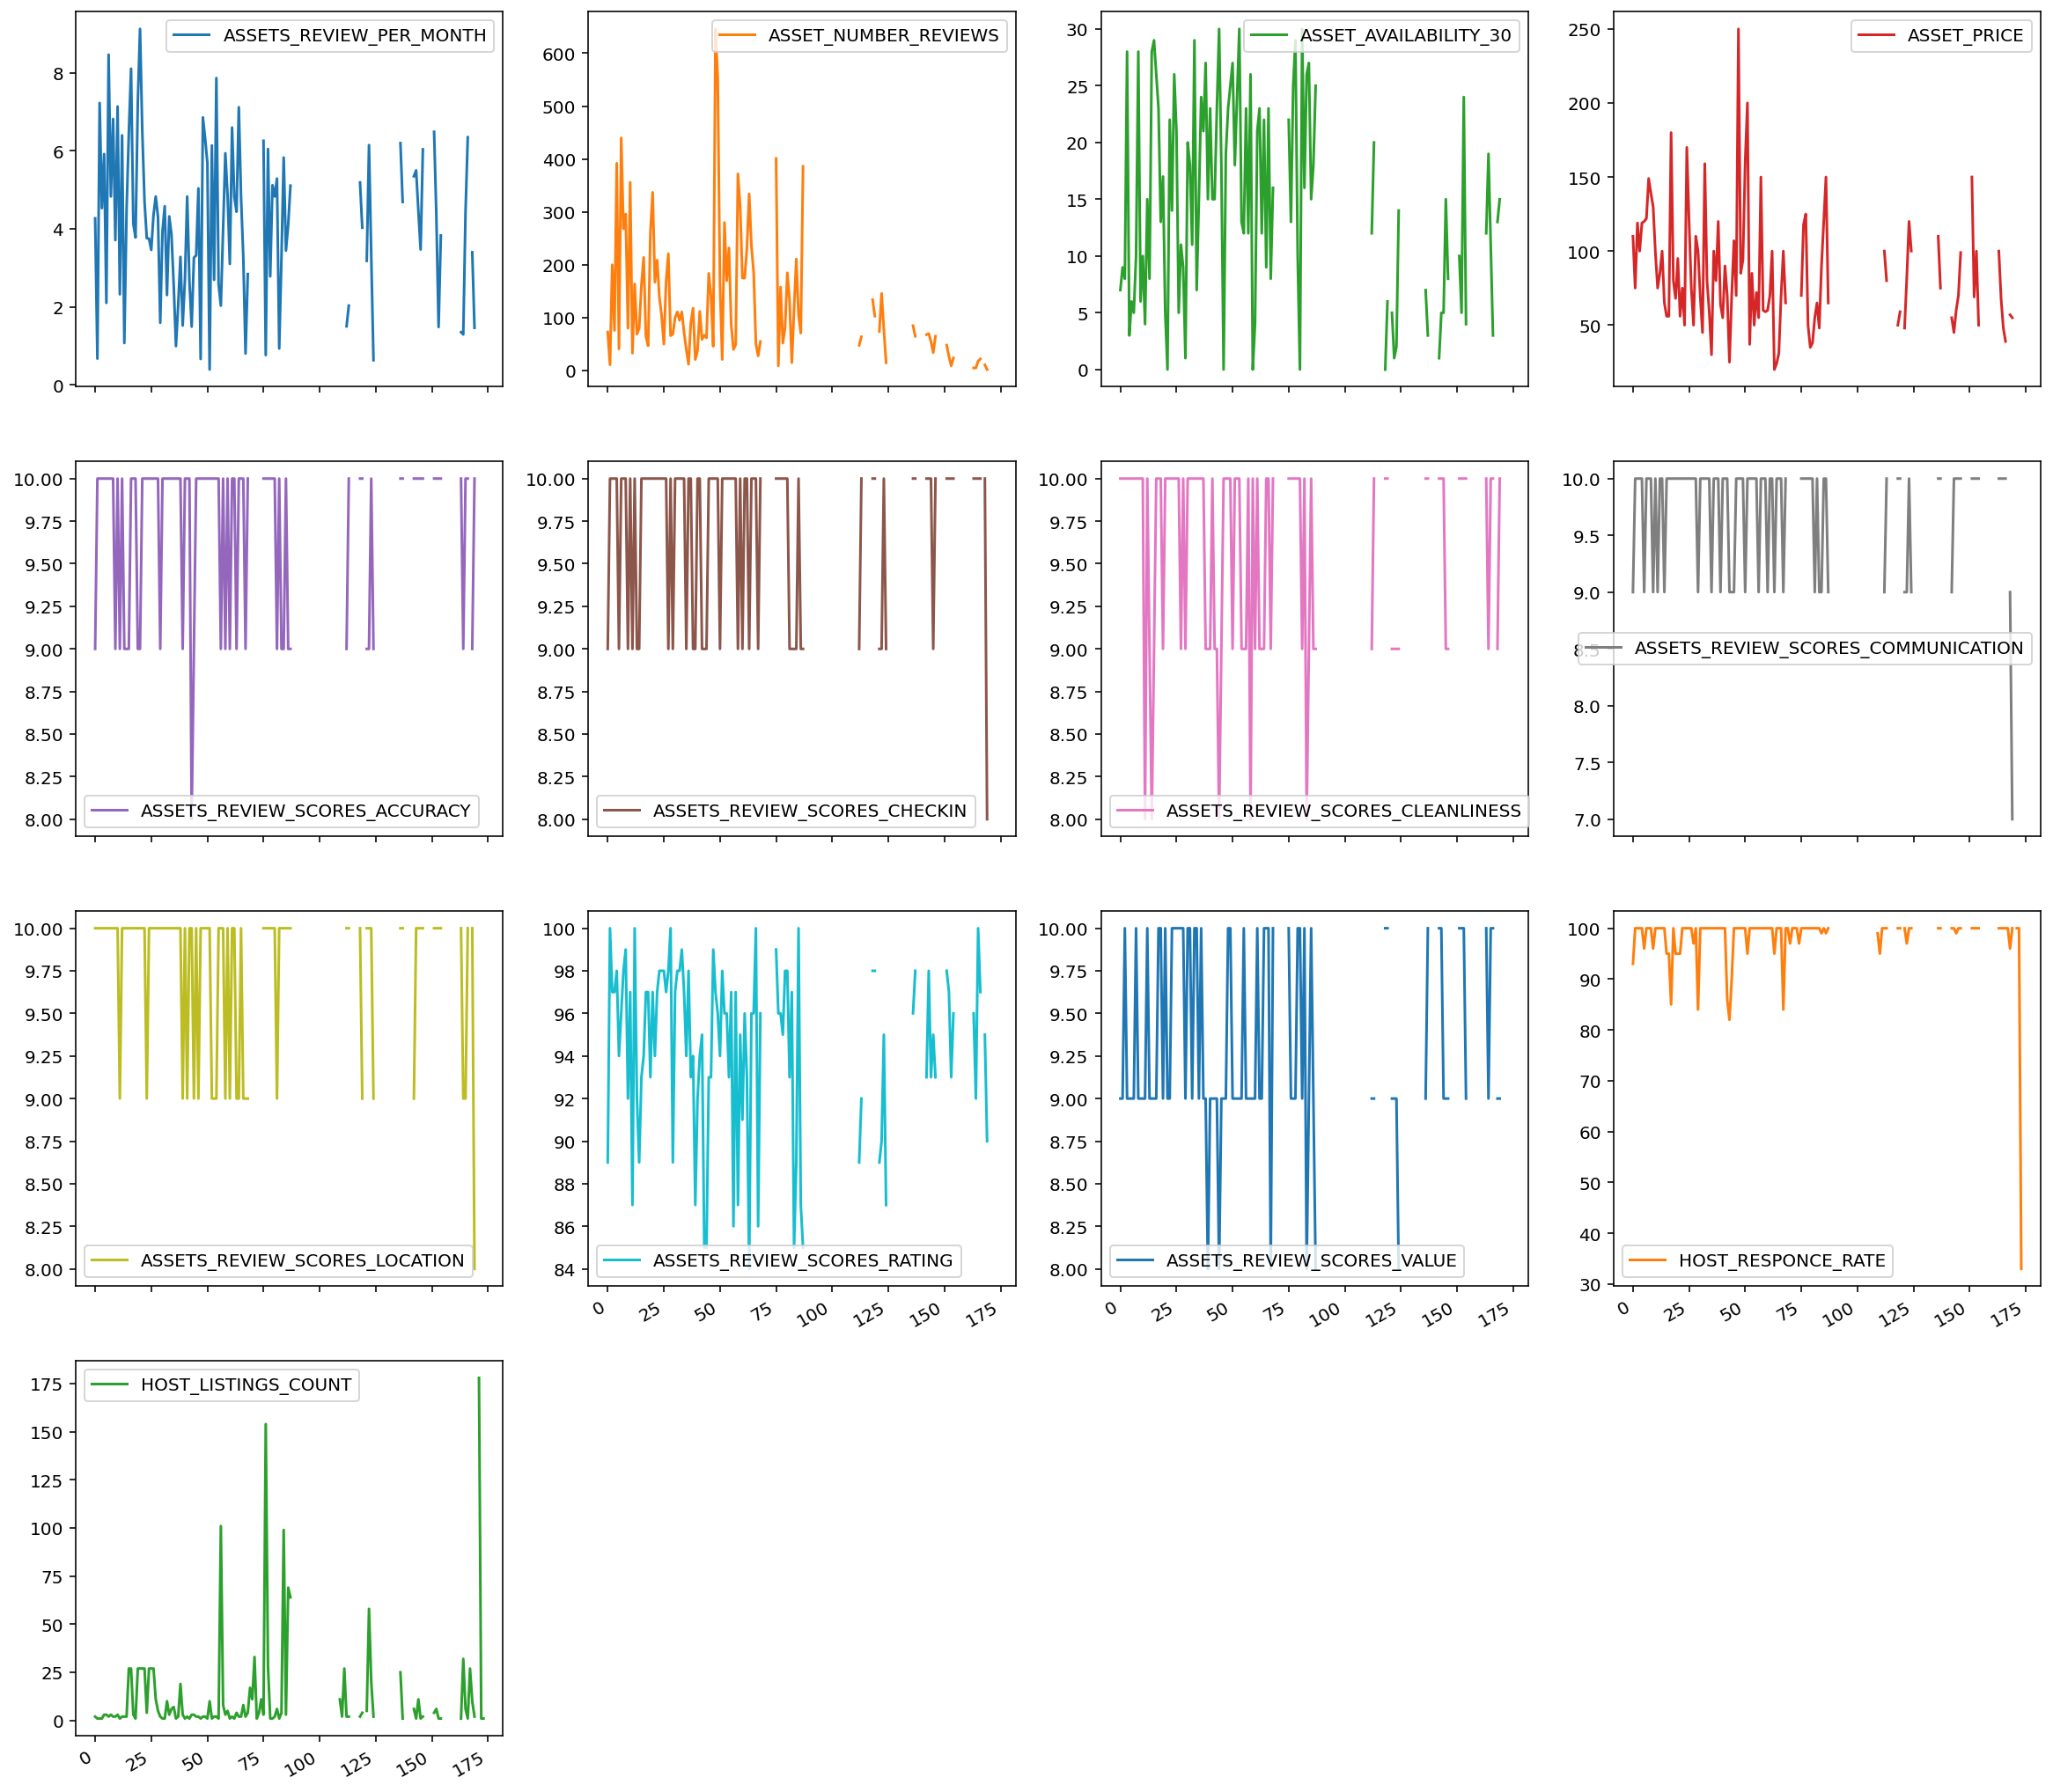

In [115]:
df_feature[numerical_features].plot(subplots=True, layout=(4,4), figsize=(20, 20))

In [116]:
# escludo gli asset con prezzo > 1000. Possibili anomalie di inserimento o altro
df_feature = df_feature[df_feature.ASSET_PRICE < 1000]

In [117]:
df_feature[["ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_RATING", "ASSETS_REVIEW_SCORES_VALUE"]].head(3)

,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
0,9.0,89.0,9.0
1,10.0,100.0,9.0
2,10.0,97.0,10.0


In [118]:
df_feature[["ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_RATING", "ASSETS_REVIEW_SCORES_VALUE"]].corr()

,ASSETS_REVIEW_SCORES_ACCURACY,ASSETS_REVIEW_SCORES_RATING,ASSETS_REVIEW_SCORES_VALUE
ASSETS_REVIEW_SCORES_ACCURACY,1.000000,0.778217,0.509362
ASSETS_REVIEW_SCORES_RATING,0.778217,1.000000,0.710341
ASSETS_REVIEW_SCORES_VALUE,0.509362,0.710341,1.000000


In [119]:
df_feature[["ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_RATING", "ASSETS_REVIEW_SCORES_VALUE"]].isnull().sum()

ASSETS_REVIEW_SCORES_ACCURACY    0
ASSETS_REVIEW_SCORES_RATING      0
ASSETS_REVIEW_SCORES_VALUE       0
dtype: int64

In [120]:
# scelgo di tenere solo ASSETS_REVIEW_SCORES_RATING --> avendo una scala più ampia magari conserva anche più variabilità

In [121]:
# per tutte le variabili che indicano caratteristiche del listing, faccio una media dei diversi voti
df_feature["ASSETS_REVIEW_SCORES_AVG"] = df_feature[["ASSETS_REVIEW_SCORES_CHECKIN", "ASSETS_REVIEW_SCORES_CLEANLINESS", 
                                                     "ASSETS_REVIEW_SCORES_COMMUNICATION", "ASSETS_REVIEW_SCORES_LOCATION",
                                                     "ASSETS_REVIEW_SCORES_ACCURACY", "ASSETS_REVIEW_SCORES_VALUE"]]\
                                        .mean(axis=1).round(2)

df_feature.drop(columns=["ASSETS_REVIEW_SCORES_CHECKIN", "ASSETS_REVIEW_SCORES_CLEANLINESS", 
                "ASSETS_REVIEW_SCORES_COMMUNICATION", "ASSETS_REVIEW_SCORES_LOCATION",
                "ASSETS_REVIEW_SCORES_ACCURACY","ASSETS_REVIEW_SCORES_VALUE"], axis=1, inplace=True)

In [122]:
# creo la variabile occupancy come differenza rispetto ai gg del mese

df_feature['OCCUPANCY'] = 30 - df_feature["ASSET_AVAILABILITY_30"]
df_feature.drop("ASSET_AVAILABILITY_30", axis=1, inplace=True)

In [123]:
df_feature[df_feature.ASSET_ID.duplicated(keep=False)]

,PARTIES_ID,ASSET_ID,ASSETS_TYPE,ASSET_LOCATION,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_RATING,TIME_STAMP_MONTH,HOST_RESPONSE_TIME,HOST_RESPONCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_HAS_PROFILE_PIC,ASSETS_REVIEW_SCORES_AVG,OCCUPANCY
23,27694497,18438350,Real Bed,lisbon,3.76,139.0,1.0,2020-06,50.0,98.0,2020-06,within an hour,100.0,t,4.0,t,9.83,16.0
24,17125483,23357734,Real Bed,lisbon,3.75,104.0,1.0,2020-06,170.0,98.0,2020-06,within an hour,100.0,t,27.0,t,10.00,4.0
26,17125483,17514847,Real Bed,lisbon,4.36,169.0,1.0,2020-06,75.0,97.0,2020-06,within an hour,100.0,t,27.0,t,10.00,25.0
27,3716977,14854589,Real Bed,lisbon,4.83,221.0,1.0,2020-06,50.0,98.0,2020-06,within an hour,97.0,t,11.0,t,9.67,19.0
28,72294821,31437575,Real Bed,lisbon,4.30,66.0,1.0,2020-06,110.0,100.0,2020-06,within an hour,100.0,t,5.0,t,10.00,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,235012325,32095892,Real Bed,lisbon,4.43,18.0,0.0,2019-06,48.0,100.0,2019-06,within an hour,100.0,t,6.0,t,9.83,19.0
166,243718511,32444327,Real Bed,madrid,6.35,22.0,0.0,2019-06,39.0,97.0,2019-06,within an hour,100.0,f,1.0,t,10.00,27.0
168,113864545,32735824,Real Bed,madrid,3.40,11.0,0.0,2019-06,57.0,95.0,2019-06,within an hour,96.0,f,10.0,t,9.33,17.0
169,222511575,32981093,Real Bed,madrid,1.46,2.0,0.0,2019-06,55.0,90.0,2019-06,within an hour,100.0,f,2.0,t,8.67,15.0


In [124]:
# dumming delle variabili categoriche scelte

dummies_cols = [
                "ASSET_LOCATION", 
                "HOST_RESPONSE_TIME", 
                "HOST_IS_SUPERHOST", 
               ]

col_to_drop = ["ASSETS_TYPE", "HOST_HAS_PROFILE_PIC"]

for col in dummies_cols:
    df_feature = df_feature.join(pd.get_dummies(df_feature[col], prefix=col))
    df_feature.drop(col, axis=1, inplace=True)

df_feature.drop(col_to_drop, axis=1, inplace=True)

In [125]:
df_feature.columns

Index(['PARTIES_ID', 'ASSET_ID', 'ASSETS_REVIEW_PER_MONTH',
       'ASSET_NUMBER_REVIEWS', 'ASSET_MITIGATION_COVID', 'DATE_YEAR_MONTH',
       'ASSET_PRICE', 'ASSETS_REVIEW_SCORES_RATING', 'TIME_STAMP_MONTH',
       'HOST_RESPONCE_RATE', 'HOST_LISTINGS_COUNT', 'ASSETS_REVIEW_SCORES_AVG',
       'OCCUPANCY', 'ASSET_LOCATION_amsterdam', 'ASSET_LOCATION_brussels',
       'ASSET_LOCATION_lisbon', 'ASSET_LOCATION_madrid',
       'HOST_RESPONSE_TIME_within a few hours',
       'HOST_RESPONSE_TIME_within an hour', 'HOST_IS_SUPERHOST_f',
       'HOST_IS_SUPERHOST_t'],
      dtype='object')

In [126]:
df_feature.head()

,PARTIES_ID,ASSET_ID,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_RATING,TIME_STAMP_MONTH,HOST_RESPONCE_RATE,...,ASSETS_REVIEW_SCORES_AVG,OCCUPANCY,ASSET_LOCATION_amsterdam,ASSET_LOCATION_brussels,ASSET_LOCATION_lisbon,ASSET_LOCATION_madrid,HOST_RESPONSE_TIME_within a few hours,HOST_RESPONSE_TIME_within an hour,HOST_IS_SUPERHOST_f,HOST_IS_SUPERHOST_t
0,217577916,31136615,4.27,73.0,1.0,2020-06,110.0,89.0,2020-06,93.0,...,9.33,23.0,1,0,0,0,0,1,1,0
1,534213,31709186,0.67,11.0,1.0,2020-06,75.0,100.0,2020-06,100.0,...,9.83,21.0,1,0,0,0,0,1,1,0
2,176059267,23575414,7.23,200.0,1.0,2020-06,119.0,97.0,2020-06,100.0,...,10.00,22.0,1,0,0,0,0,1,0,1
3,141648682,31356236,4.53,76.0,1.0,2020-06,100.0,97.0,2020-06,100.0,...,9.83,2.0,1,0,0,0,0,1,0,1
4,2313061,771343,5.92,392.0,1.0,2020-06,119.0,98.0,2020-06,100.0,...,9.83,27.0,1,0,0,0,0,1,0,1


In [127]:
df_feature.isnull().sum()

PARTIES_ID                               0
ASSET_ID                                 0
ASSETS_REVIEW_PER_MONTH                  0
ASSET_NUMBER_REVIEWS                     0
ASSET_MITIGATION_COVID                   0
DATE_YEAR_MONTH                          0
ASSET_PRICE                              0
ASSETS_REVIEW_SCORES_RATING              0
TIME_STAMP_MONTH                         0
HOST_RESPONCE_RATE                       0
HOST_LISTINGS_COUNT                      0
ASSETS_REVIEW_SCORES_AVG                 0
OCCUPANCY                                0
ASSET_LOCATION_amsterdam                 0
ASSET_LOCATION_brussels                  0
ASSET_LOCATION_lisbon                    0
ASSET_LOCATION_madrid                    0
HOST_RESPONSE_TIME_within a few hours    0
HOST_RESPONSE_TIME_within an hour        0
HOST_IS_SUPERHOST_f                      0
HOST_IS_SUPERHOST_t                      0
dtype: int64

In [128]:
# elimino gli na per costruire il modello
df_feature.dropna(inplace=True)

In [129]:
df_feature.shape

(122, 21)

In [130]:
df_feature

,PARTIES_ID,ASSET_ID,ASSETS_REVIEW_PER_MONTH,ASSET_NUMBER_REVIEWS,ASSET_MITIGATION_COVID,DATE_YEAR_MONTH,ASSET_PRICE,ASSETS_REVIEW_SCORES_RATING,TIME_STAMP_MONTH,HOST_RESPONCE_RATE,...,ASSETS_REVIEW_SCORES_AVG,OCCUPANCY,ASSET_LOCATION_amsterdam,ASSET_LOCATION_brussels,ASSET_LOCATION_lisbon,ASSET_LOCATION_madrid,HOST_RESPONSE_TIME_within a few hours,HOST_RESPONSE_TIME_within an hour,HOST_IS_SUPERHOST_f,HOST_IS_SUPERHOST_t
0,217577916,31136615,4.27,73.0,1.0,2020-06,110.0,89.0,2020-06,93.0,...,9.33,23.0,1,0,0,0,0,1,1,0
1,534213,31709186,0.67,11.0,1.0,2020-06,75.0,100.0,2020-06,100.0,...,9.83,21.0,1,0,0,0,0,1,1,0
2,176059267,23575414,7.23,200.0,1.0,2020-06,119.0,97.0,2020-06,100.0,...,10.00,22.0,1,0,0,0,0,1,0,1
3,141648682,31356236,4.53,76.0,1.0,2020-06,100.0,97.0,2020-06,100.0,...,9.83,2.0,1,0,0,0,0,1,0,1
4,2313061,771343,5.92,392.0,1.0,2020-06,119.0,98.0,2020-06,100.0,...,9.83,27.0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,235012325,32095892,4.43,18.0,0.0,2019-06,48.0,100.0,2019-06,100.0,...,9.83,19.0,0,0,1,0,0,1,0,1
166,243718511,32444327,6.35,22.0,0.0,2019-06,39.0,97.0,2019-06,100.0,...,10.00,27.0,0,0,0,1,0,1,1,0
168,113864545,32735824,3.40,11.0,0.0,2019-06,57.0,95.0,2019-06,96.0,...,9.33,17.0,0,0,0,1,0,1,1,0
169,222511575,32981093,1.46,2.0,0.0,2019-06,55.0,90.0,2019-06,100.0,...,8.67,15.0,0,0,0,1,0,1,1,0


#### MODEL

In [137]:
#X = df_feature[[c for c in list(df_feature) if c not in ["PARTIES_ID", "ASSET_ID", "OCCUPANCY"]]]
X = df_feature[[c for c in list(df_feature) if c not in ["PARTIES_ID", "ASSET_ID", "ASSET_PRICE", 
                                                         "TIME_STAMP_MONTH", 'DATE_YEAR_MONTH']]]
#X = df_feature[[c for c in list(df_feature) if c not in ["PARTIES_ID", "ASSET_ID", "ASSET_NUMBER_REVIEWS"]]]

In [138]:
#y = df_feature["OCCUPANCY"]
y = df_feature["ASSET_PRICE"]
#y = df_feature["ASSET_NUMBER_REVIEWS"]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [141]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#### Decision Tree Regressor

In [142]:
model = dtr(max_depth=10, 
            min_samples_split=0.1, 
            min_samples_leaf=0.05, 
            random_state=101)

model.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.05,
                      min_samples_split=0.1, random_state=101)

In [143]:
pred = model.predict(X_test)

In [144]:
mape(pred, y_test.values)

39.05581041395133

In [145]:
importance = model.feature_importances_
columns = list(X_train)

df_feat_imp = pd.DataFrame({'feature' : columns, 'importance' : importance})
df_feat_imp.sort_values(by='importance', ascending = False, inplace=True)

<AxesSubplot:ylabel='feature'>

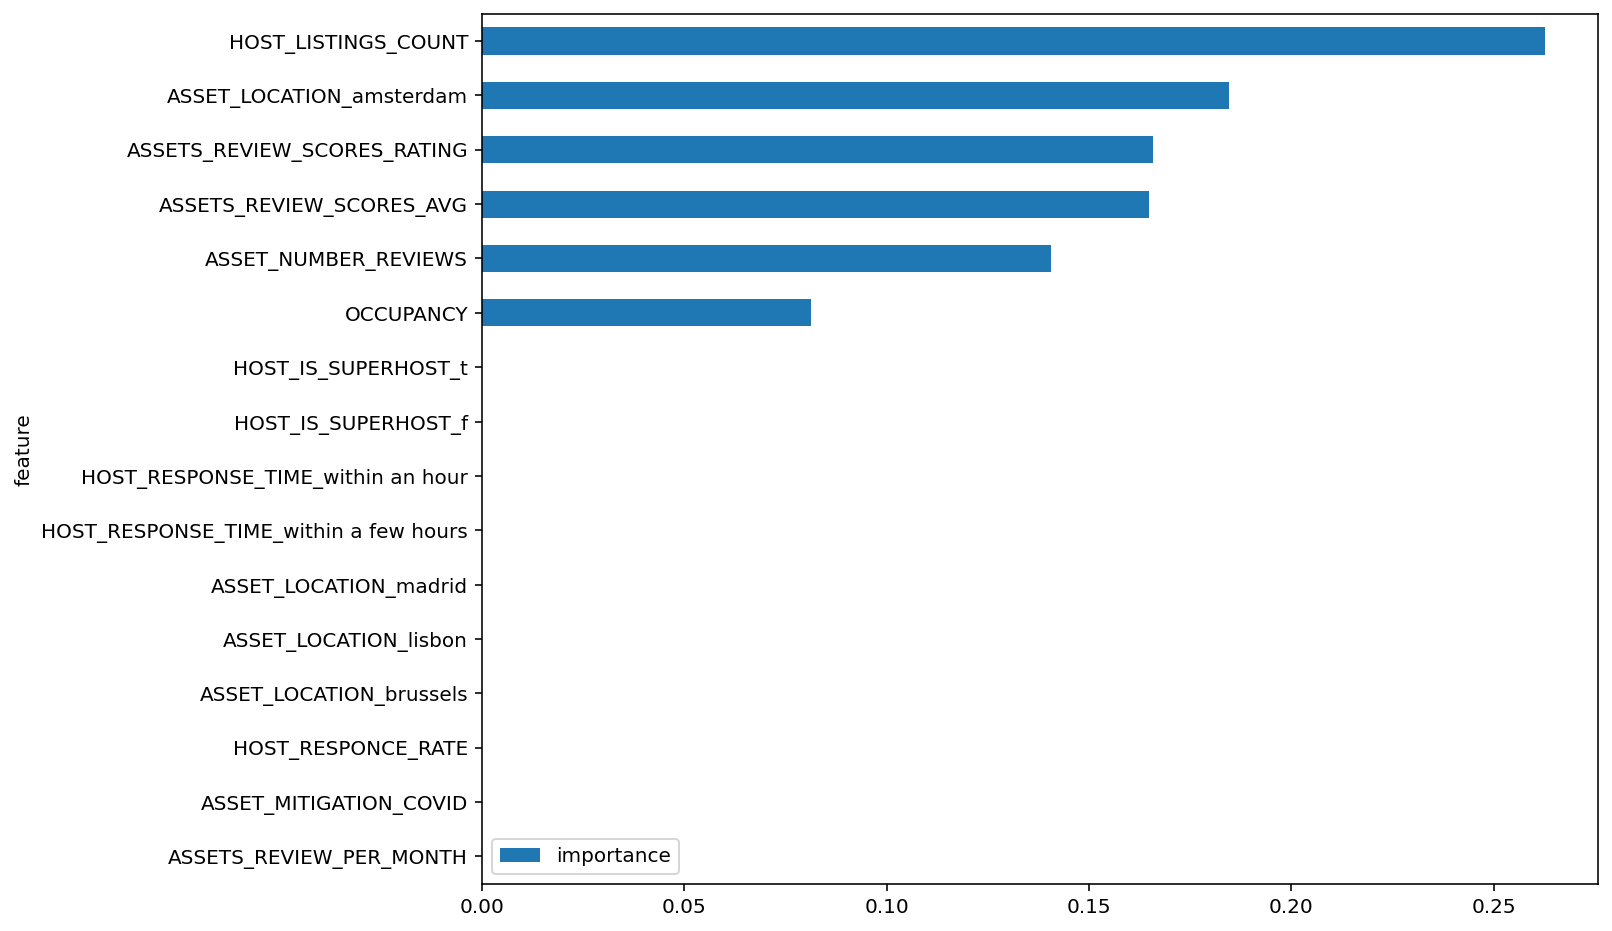

In [146]:
df_feat_imp.sort_values(by='importance', ascending = True)\
           .plot.barh(x="feature", y="importance", figsize=(10, 8))

In [147]:
df_test = pd.DataFrame({'actual' : y_test.values, 'predicted' : pred})

In [148]:
df_test.sort_values(by='actual').head(10)

,actual,predicted
15,25.0,52.666667
18,31.0,41.400000
16,39.0,80.666667
21,45.0,80.666667
32,45.0,80.666667
6,50.0,118.000000
34,50.0,64.000000
10,50.0,89.800000
3,56.0,67.200000
14,56.0,67.200000


In [149]:
df_feature[df_feature.OCCUPANCY < 5].shape[0] / df_feature.shape[0]

0.13934426229508196

#### Regression

In [150]:
reg = lr().fit(X_train, y_train)

In [151]:
# coefficient of determination R2 of the prediction.
reg.score(X_train, y_train)

0.44923491604656685

In [152]:
reg.coef_

array([  3.80913694,  -0.11099744,  -2.62774792,   1.98373992,
        -1.86455173,   0.36868953,  36.79293714,  -0.78525792,
        32.42148779, -14.36204772,  -0.64246396, -17.41697611,
        14.55303959, -14.55303959,  14.41324141, -14.41324141])

In [153]:
lr_pred = reg.predict(X_test)

In [154]:
mape(lr_pred, y_test.values)

32.70936524088628

In [155]:
df_test_lr = pd.DataFrame({'actual' : y_test.values, 'predicted' : lr_pred})

In [156]:
df_test_lr.sort_values(by='actual').head(10)

,actual,predicted
15,25.0,73.060725
18,31.0,91.870885
16,39.0,109.789111
21,45.0,92.251056
32,45.0,92.725753
6,50.0,123.997841
34,50.0,63.688327
10,50.0,132.161075
3,56.0,70.251535
14,56.0,91.545980
